# Question Generation For Retrieval Evaluation

MLflow provides an advanced framework for constructing Retrieval-Augmented Generation (RAG) models.
RAG is a cutting edge approach that combines the strengths of retrieval models (a model that chooses and ranks relevant 
chunks of a document based on the user's question) and generative models.
It effectively merges the capabilities of searching and generating text to provide responses that are contextually
relevant and coherent, allowing the generated text to make reference to existing documents. RAG leverges the retriever to find context documents, and
this novel approach has revolutionized various NLP tasks.

Naturally, we want to be able to evaluate this retriever system for the RAG model to compare and judge its
performance. To evaluate a retriever system, we would first need a test set of questions on the documents.
These questions need to be diverse, relevant, and coherent. Manually generating questions may be challenging
because it first requires you to understand the documents, and spend lots of time coming up with questions 
for them. 

We want to make this process simpler by utilizing an LLM to generate questions for this test set. This
tutorial will walk through how to generate the questions and how to analyze the diversity and relevance
of the questions.

## Step 1: Install and Load Packages

We also define some utility functions to cache the LLM responses to save cost. You can skip reading the implementation details in the next cell.

In [54]:
# !pip install beautifulsoup4 langchain openai pandas seaborn scikit-learn

In [55]:
import json
import os

# For cost-saving, create a cache for the LLM responses
import threading

# For data analysis and visualization
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

# For scraping
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


class Cache:
    def __init__(self, persist_path, cache_loading_fn):
        """
        The cache_loading_fn should be a function that takes arbitrary
        serializable arguments and returns a serilaizable value.
          value = cache_loading_fn(**kwargs)
        For example, for openai.chat.completions.create(...), the
        cache_loading_fn should be:
          def cache_loading_fn(**kwargs):
            result = openai.chat.completions.create(**kwargs)
            return result.to_dict_recursive()
        """
        self._cache = self._get_or_create_cache_dict(persist_path)
        self._persist_path = persist_path
        self._cache_loading_fn = cache_loading_fn
        self._cache_lock = threading.Lock()

    @classmethod
    def _get_or_create_cache_dict(cls, persist_path):
        if os.path.exists(persist_path):
            # File exists, load it as a JSON string into a dict
            with open(persist_path) as f:
                cache = json.load(f)
        else:
            # File does not exist, create an empty dict
            cache = {}
        return cache

    def _save_to_file(self):
        with open(self._persist_path, "w") as file:
            json.dump(self._cache, file)

    def _update_cache(self, key, value):
        with self._cache_lock:
            self._cache[key] = value
            self._save_to_file()

    def get_from_cache_or_load_cache(self, **kwargs):
        key = json.dumps(kwargs)

        with self._cache_lock:
            value = self._cache.get(key, None)

        if value is None:
            value = self._cache_loading_fn(**kwargs)
            self._update_cache(key, value)
        else:
            print("Loaded from cache")

        return value


def chat_completion_create_fn(**kwargs):
    result = openai.chat.completions.create(**kwargs)
    # print("Created new chat completion", result.choices[0].message)
    return result.choices[0].message.function_call.arguments


def cached_openai_ChatCompletion_create(**kwargs):
    cache = kwargs.pop("cache")
    return cache.get_from_cache_or_load_cache(**kwargs)


def embeddings_embed_documents_fn(**kwargs):
    chunk = kwargs.get("chunk")
    return embeddings.embed_documents([chunk])


def cached_langchain_openai_embeddings(**kwargs):
    cache = kwargs.pop("cache")
    return cache.get_from_cache_or_load_cache(**kwargs)

## Step 2: Set OpenAI Key

The question generation system can be done using any LLM. We chose to use OpenAI here, so we will need their API key.

In [ ]:
from dotenv import load_dotenv

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai.api_key

In [57]:
# Other configurations

# Choose a seed for reproducible results
SEED = 2023

# For cost-saving purposes, choose a path to persist the responses for LLM calls
CACHE_PATH = "_cache.json"
EMBEDDINGS_CACHE_PATH = "_embeddings_cache.json"

# To avoid re-running the scraping process, choose a path to save the scrapped docs
GENERATED_DATA_PATH = "generated_emails.json"

# Choose a path to save the generated dataset
OUTPUT_DF_PATH = "question_answer_source.csv"

In [58]:
cache = Cache(CACHE_PATH, chat_completion_create_fn)
embeddings_cache = Cache(EMBEDDINGS_CACHE_PATH, embeddings_embed_documents_fn)

## Step 3: Decide on Chunk Size

In [59]:
CHUNK_SIZE = 1500

## Step 4: Prepare Document Data

### Scrape the documents from the MLflow website

In [61]:
import json

with open(GENERATED_DATA_PATH) as data_file:    
    data = json.load(data_file)  

df = pd.json_normalize(data)
df

,metadata.message_id,metadata.from_email,metadata.to,metadata.cc,metadata.bcc,metadata.subject,metadata.date,content.html,content.plain_text,content.reference_summary,analytics.topic,analytics.industry,analytics.is_toxic,analytics.length
0,email_002,sender0@example.com,[recipient0@company.com],[manager0@company.com],[],Invitation: Enhancing Finance Capabilities in ...,2025-01-07T00:42:16.485128Z,<html><body><p>Subject: Invitation: Enhancing ...,Subject: Invitation: Enhancing Finance Capabil...,Subject: Invitation: Enhancing Finance Capabil...,Meeting Invitations,Finance,False,1612
1,email_002,mcdaniellauren@example.net,[zlawson@example.net],[browningstacy@example.org],[],Invitation to Retail Industry Roundtable Discu...,2025-03-09T00:22:20.644416Z,NaN,Subject: Invitation to Retail Industry Roundta...,NaN,Meeting Invitations,Retail,False,1636
2,email_003,gabrieldaniel@example.com,[savannahmontgomery@example.org],[cherylblack@example.com],[],Updates on Project Vega: New Features and Impr...,2025-02-19T03:20:32.251941Z,NaN,Subject: Updates on Project Vega: New Features...,NaN,Project Updates,Tech,True,1956
3,email_004,allen48@example.org,[rhondapaul@example.org],[zmcguire@example.com],[],Invitation to Q2 Financial Report Presentation...,2024-10-10T12:49:41.822953Z,NaN,Subject: Invitation to Q2 Financial Report Pre...,NaN,Financial Reports,Healthcare,False,1753
4,email_005,rmcneil@example.com,[moranchristopher@example.org],[johnsoncharles@example.org],[],Enhancement of Customer Support Services for G...,2024-12-24T10:27:53.403274Z,NaN,Subject: Enhancement of Customer Support Servi...,NaN,Customer Support,Government,False,1865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,email_185,yperkins@example.com,[stephaniecarroll@example.org],[],[],Essential Update: Recent Security Alerts in th...,2024-11-03T23:44:34.782223Z,NaN,Subject: Essential Update: Recent Security Ale...,NaN,Security Alerts,Education,False,2253
183,email_186,molly48@example.org,[carmstrong@example.net],[],[],Invitation: Upcoming Global Healthcare Symposi...,2024-12-21T08:59:44.136424Z,NaN,Subject: Invitation: Upcoming Global Healthcar...,NaN,Event and Flight Tickets,Healthcare,False,1937
184,email_187,johnmiller@example.org,[haley88@example.com],[lhardy@example.org],[],"Inviting You To ""The Future of Education"" Conf...",2024-07-13T22:33:54.460339Z,NaN,"Subject: Inviting You To ""The Future of Educat...",NaN,Event and Flight Tickets,Education,False,1897
185,email_188,lsharp@example.net,[crystalrhodes@example.org],[],[],Invitation to 2022 Healthcare Industry Symposi...,2025-02-24T17:45:07.017128Z,NaN,Subject: Invitation to 2022 Healthcare Industr...,NaN,Event and Flight Tickets,Healthcare,False,2047


## Step 5: Generate questions

The prompt below instructs the LLM to generate a question for each given chunk, and also generate an answer to the question to make it easier to do human validation. Also, return the results in a structured format.

This example uses OpenAI's gpt-4o-mini model to generate the questions, you can replace it with the LLM that works best for your use case.

In [64]:
def get_raw_response(content):
    prompt = f"""Please generate a question asking for the key information in the given email.
    Also answer the questions using the information in the given email.
    Please ask the specific question instead of the general question, like
    'What is the key information in the given email?'.
    Please generate the answer using as much information as possible.
    If you are unable to answer it, please generate the answer as 'I don't know.'
    The answer should be informative and should be more than 3 sentences.

    Email: {content}

    Please call the submit_function function to submit the generated question and answer.
    """

    messages = [{"role": "user", "content": prompt}]

    submit_function = {
        "name": "submit_function",
        "description": "Call this function to submit the generated question and answer.",
        "parameters": {
            "type": "object",
            "properties": {
                "question": {
                    "type": "string",
                    "description": "The question asking for the key information in the given email.",
                },
                "answer": {
                    "type": "string",
                    "description": "The answer to the question using the information in the given email.",
                },
            },
            "required": ["question", "answer"],
        },
    }

    response = cached_openai_ChatCompletion_create(
        messages=messages,
        model="gpt-4o-mini",
        functions=[submit_function],
        function_call="auto",
        temperature=0.0,
        seed=SEED,
        cache=cache,
    )
    # print("Response: ", response)
    return response


def generate_question_answer(content):
    if content is None or len(content) == 0:
        return "", "N/A"

    response = get_raw_response(content)
    # print(response)
    try:
        func_args = json.loads(response)
        question = func_args["question"]
        answer = func_args["answer"]
        return question, answer
    except Exception as e:
        return str(e), "N/A"

In [66]:
# The requests sometimes get ratelimited, you can re-execute this cell without losing the existing results.
queries = []
n = len(df)
for i, row in df.iterrows():
    chunk = row["content.plain_text"]
    question, answer = generate_question_answer(chunk)
    # print(f"{i + 1}/{n}: {question}")
    queries.append(
        {
            "question": question,
            "answer": answer,
            "email": chunk,
            "chunk_id": row["metadata.message_id"],
            "topic": row["analytics.topic"],
            "industry": row["analytics.industry"],
        }
    )

Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache


Sometimes, the LLM may fail to generate a question. We can examine the data above to see whether there are any errors. If so, remove the error records.

In [67]:
result_df = pd.DataFrame(queries)
result_df = result_df[result_df["answer"] != "N/A"]

In [68]:
result_df

,question,answer,email,chunk_id,topic,industry
0,What are the details of the event 'Enhancing F...,The event 'Enhancing Finance Capabilities in t...,Subject: Invitation: Enhancing Finance Capabil...,email_002,Meeting Invitations,Finance
1,What are the details of the Retail Industry Ro...,The Retail Industry Roundtable Discussion is o...,Subject: Invitation to Retail Industry Roundta...,email_002,Meeting Invitations,Retail
2,What are the key updates regarding Project Veg...,The email provides several key updates on Proj...,Subject: Updates on Project Vega: New Features...,email_003,Project Updates,Tech
3,What are the details of the Q2 Financial Repor...,The Q2 Financial Report Presentation and Analy...,Subject: Invitation to Q2 Financial Report Pre...,email_004,Financial Reports,Healthcare
4,What opportunity is Robert Johnson offering to...,"Robert Johnson, the Head of Government Relatio...",Subject: Enhancement of Customer Support Servi...,email_005,Customer Support,Government
...,...,...,...,...,...,...
182,What recent security threats have been observe...,"According to the email, there has been a notab...",Subject: Essential Update: Recent Security Ale...,email_185,Security Alerts,Education
183,What are the details of the upcoming Global He...,The upcoming Global Healthcare Symposium is sc...,Subject: Invitation: Upcoming Global Healthcar...,email_186,Event and Flight Tickets,Healthcare
184,What are the details of the conference invitat...,Dr. Jennifer Harding is invited to the annual ...,"Subject: Inviting You To ""The Future of Educat...",email_187,Event and Flight Tickets,Education
185,What are the details of the invitation extende...,Dr. Benjamin Harvey has been invited to partic...,Subject: Invitation to 2022 Healthcare Industr...,email_188,Event and Flight Tickets,Healthcare


In [69]:
def add_to_output_df(result_df=pd.DataFrame({})):
    """
    This function adds the records in result_df to the existing records saved at OUTPUT_DF_PATH,
    remove the duplicate rows and save the new collection of records back to OUTPUT_DF_PATH.
    """
    if os.path.exists(OUTPUT_DF_PATH):
        all_result_df = pd.read_csv(OUTPUT_DF_PATH)
    else:
        all_result_df = pd.DataFrame({})
    all_result_df = (
        pd.concat([all_result_df, result_df], ignore_index=True)
        .drop_duplicates()
        .sort_values(by=["email", "chunk_id"])
        .reset_index(drop=True)
    )
    all_result_df.to_csv(OUTPUT_DF_PATH, index=False)
    return all_result_df

In [70]:
all_result_df = add_to_output_df(result_df)

In [71]:
all_result_df.head(3)

,question,answer,email,chunk_id,topic,industry
0,What are the details of the Advanced Technical...,The Advanced Technical Training event hosted b...,Subject: Advanced Technical Training on New He...,email_140,Technical Documentation,Healthcare
1,What are the key details regarding the 2021 Fi...,The email informs Mrs. Patricia Weston about t...,Subject: Analysis of 2021 Financial Reports fo...,email_058,Financial Reports,Education
2,What are the key details regarding the upcomin...,The upcoming analysis discussion of the Q2 fin...,Subject: Analysis of Q2 Financial Reports: Und...,email_060,Financial Reports,Education


## Quality Analysis of Questions Generated (Optional)

If you would like to compare quality of questions generated across different prompts, we can
analyze the quality of questions manually and in aggregate. We want to evaluate questions 
along two dimensions - their diversity and relevance.

https://github.com/mlflow/mlflow/blob/master/examples/llms/question_generation/question_answer_source.csv is a pre-generated dataset with 56 questions. You can download it and specify the path with `OUTPUT_DF_PATH`, and load it to run the rest of the notebook if you want to jump to this section.

Note: There isn't a well-defined way to analyze the quality of generated questions, so this is just one approach you can take to gain insight into how diverse and relevant your generated questions are.

In [72]:
all_result_df = add_to_output_df()

### Evaluating Diversity of Questions

Diversity of questions is important because we want questions to cover the majority of the
document content. In addition, we want to be able to evaluate the retriever with different 
forms of questioning. We want to be able to have harder questions and easier questions. All
of these are not straightforward to analyze, and we decided to analyze its through question
length and latent space embeddings.

#### Length

Length gives a sense of how diverse the questions are. Some questions may be wordy while
others are straight to the point. It also allows us to identify problems with the question
generated.

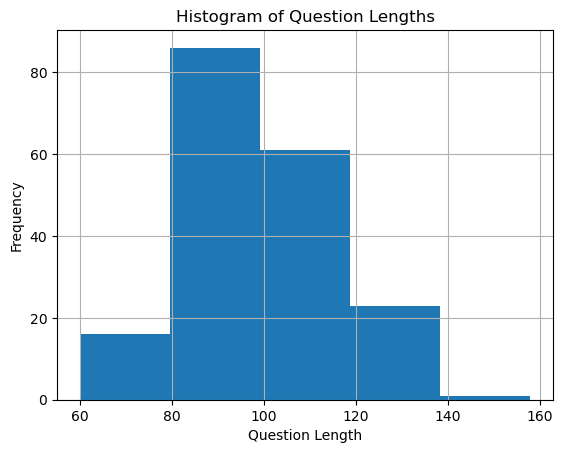

In [73]:
# Length
questions = all_result_df["question"].to_list()
question_len = pd.DataFrame([len(q) for q in questions], columns=["length"])
question_len.hist(bins=5)
plt.title("Histogram of Question Lengths")
plt.xlabel("Question Length")
plt.ylabel("Frequency")
plt.show()

In addition to visual representation, we also want to look at more concrete percentile values.


In [74]:
# Calculating percentile values
p10 = int(question_len["length"].quantile(0.10))
p90 = int(question_len["length"].quantile(0.90))
print("p10-p90 range is", p90 - p10)

p10-p90 range is 42


There are also a couple queries that are longer than normal. However, these seem fine.

In [75]:
[q for q in questions if len(q) > 100]

['What are the key details regarding the 2021 Financial Reports analysis for the Education Industry mentioned in the email?',
 'What are the key details regarding the upcoming analysis discussion of the Q2 financial reports in the education industry?',
 'What new features are being introduced in the EduTech Customer Support platform to enhance the education experience?',
 'What are the key updates and next steps regarding the Azure Innovations project as mentioned in the email?',
 'What innovative marketing strategies is MedHealth Innovations proposing to enhance patient engagement?',
 "What marketing strategies does Inteli-Edu Solutions propose to enhance the University of Prestige's enrollment and student success?",
 'What are the key details regarding the upcoming marketing campaigns in the Tech industry mentioned in the email?',
 'What key insights does the financial report from Medico Health Solutions provide regarding the healthcare industry?',
 'What are the key insights shared 

#### Latent Space

Latent space embeddings contain semantic information about the question. This can be used to 
evaluate the diversity and the difference between two questions semantically. To do so, we will need to map the
high dimensional space to a lower dimensional space. We utilize PCA and TSNE to map the embeddings 
into a 2-dimensional space for visualization.

We append 5 benchmark queries to help visualize how diverse the questions are. The first four of these questions are semantically similar and all asking about MLflow, while the last is different and asks about RAG.

In [76]:
benchmark_questions = [
    'What services does Elliot Management Solutions offer to improve customer support at Davidson Supermarkets?',
    'What are the details of the exclusive Masterclass on Advanced Retail Sales Pitches mentioned in the email?',
    "What are the details of the conference titled 'Amplifying Sales Through Effective Pitches' mentioned in the email?",
    "What are the details and purpose of the 'Retail Evolution Summit 2022' invitation extended to Ms. Claire Sanders?",
    "What are the key details of the 'Transforming Retail - Strategy and Innovation Summit' mentioned in the email?",
    "What are the details of the 'Sales Pitches: Retail Industry Edition' workshop mentioned in the email?",
    'What are the key details regarding the latest technical documentation update for ABC Retail Corporation?',
    'What are the details and purpose of the Mastering Retail Sales Pitches workshop mentioned in the email?',
    'What details are provided about the upcoming release of the updated Technical Documentation for the retail sector?',
    "What insights does John Preston provide regarding the retail industry's financial performance for Q2?"
]
questions_to_embed = questions + benchmark_questions

We apply PCA to reduce the embedding dimensions to 10 before applying TSNE to reduce it to 2 dimensions, as recommended by sklearn due to the computational complexity of TSNE.

In [77]:
# Apply embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
question_embeddings = embeddings.embed_documents(questions)


In [78]:
# PCA on embeddings to reduce to 10-dim
pca = PCA(n_components=10, random_state=SEED)
question_embeddings_reduced = pca.fit_transform(question_embeddings)
# TSNE on embeddings to reduce to 2-dim
tsne = TSNE(n_components=2, perplexity=10, max_iter=1000, random_state=SEED)
lower_dim_embeddings = tsne.fit_transform(question_embeddings_reduced)

Now that we have 2-dimensional embeddings representing the semantics of the question, we can visualize it with a scatter plot, differentiating the generated questions and the benchmark questions.

<Axes: xlabel='x', ylabel='y'>

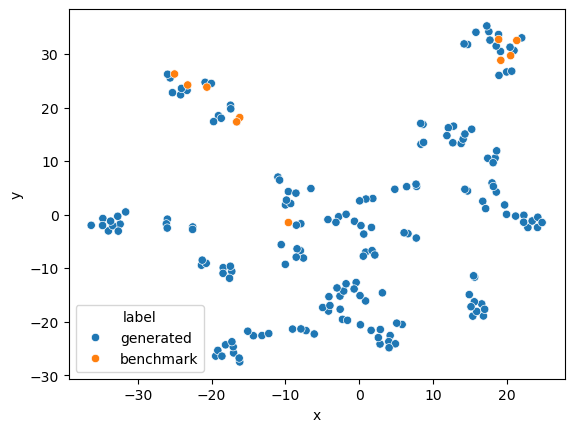

In [79]:
labels = np.concatenate(
    [
        np.full(len(lower_dim_embeddings) - len(benchmark_questions), "generated"),
        np.full(len(benchmark_questions), "benchmark"),
    ]
)
data = pd.DataFrame(
    {"x": lower_dim_embeddings[:, 0], "y": lower_dim_embeddings[:, 1], "label": labels}
)
sns.scatterplot(data=data, x="x", y="y", hue="label")

Observe that within the orange points on the scatter plot, there is one point that is further than the others. That is the unique benchmark question about RAG. This plot gives a sense of the diversity of the questions generated.

### Evaluate Document Relevance

Another important axis to consider is how relevant the questions are to the document we provided. We want to understand whether the questions generated by the LLM is actually referring to our provided text, or whether it is hallucinating irrelevant questions. We will evaluate relevance by first manually checking certain questions against their document chunk. Then, we define a measure of relevance to analyze it quantitatively.

#### Manual Checking of Document Relevance

Manual qualitative check of whether the questions are relevant to the document.

In [80]:
all_result_df.sample(3)

,question,answer,email,chunk_id,topic,industry
103,What are the key details regarding the Future ...,The Future of Retail Symposium is scheduled fo...,Subject: Invitation to The Future of Retail Sy...,email_163,Event Invitations,Retail
61,What are the key details regarding the cyberse...,"The email from Dr. Katherine Wright, the Senio...",Subject: Important Security Alerts Pertaining ...,email_171,Security Alerts,Government
35,What recent security threats have been observe...,"According to the email, there has been a notab...",Subject: Essential Update: Recent Security Ale...,email_185,Security Alerts,Education


#### Embeddings Cosine Similarity

The embedding of the chunk and query is placed in the same latent space, and the retriever model would extract similar chunk embeddings to a query embedding. Hence, relevance for the retriever is defined by the distance of embeddings in this latent space.

Cosine similarity is a measure of vector similarity, and can be used to determine the distance of embeddings between the chunk and the query. It is a distance metric that approaches 1 when the question and chunk are similar, and becomes 0 when they are different.

We can use the cosine similarity score directly to measure the relevancy.

In [81]:
embedded_queries = all_result_df.copy()
embedded_queries["chunk_emb"] = all_result_df["email"].apply(
    lambda x: np.squeeze(cached_langchain_openai_embeddings(chunk=x, cache=embeddings_cache))
)
embedded_queries["question_emb"] = all_result_df["question"].apply(
    lambda x: np.squeeze(cached_langchain_openai_embeddings(chunk=x, cache=embeddings_cache))
)

Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded from cache
Loaded fro

In [82]:
def cossim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


embedded_queries["cossim"] = embedded_queries.apply(
    lambda row: cossim(row["question_emb"], row["chunk_emb"]), axis=1
)

After we score each question by its relative relevancy, we can evaluate the generated questions as a whole.

(array([  3.,  12.,  24., 110.,  38.]),
 array([0.36945938, 0.4539184 , 0.53837741, 0.62283643, 0.70729544,
        0.79175446]),
 <BarContainer object of 5 artists>)

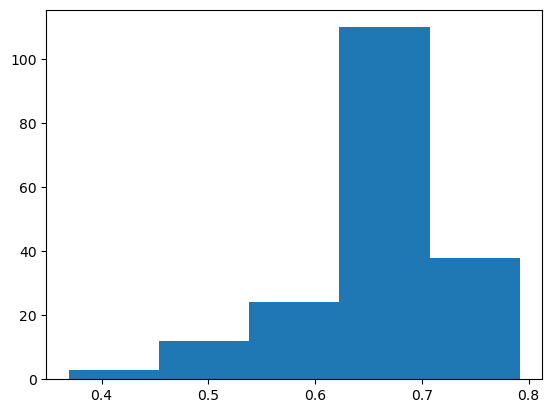

In [83]:
scores = embedded_queries["cossim"].to_list()
plt.hist(scores, bins=5)

There are a couple lower scores. Let's take a look at them.

In [84]:
mask = embedded_queries["cossim"] < 0.55
lower_cossim = embedded_queries[mask]
for i, row in lower_cossim.iterrows():
    print(f"Question: {i}")
    print(row["question"])
    print("Chunk:")
    print(row["email"])
    print("cossim:")
    print(row["cossim"])

Question: 5
What are the details and purpose of the upcoming webinar mentioned in the email?
Chunk:
Subject: Boost Your Bottom Line: Innovative Marketing Strategies for Retail <br><br>Dear Margaret Thompson,<br><br>I hope this email finds you well. My name is James Roberts and I am the Head of Business Development here at Marketing Dynamics, a reputable marketing agency renowned for delivering transformative results to clients across a variety of sectors including retail.<br><br>In light of recent trends and transformations in the retail industry, we are hosting an exclusive webinar on Thursday, 14th of April, at 10:00 a.m. EDT titled “Sales Uplift: Innovative Marketing Strategies for Retail.” This is designed to equip businesses like yours with insights into successful marketing campaigns that can amplify your retail sales, increase brand visibility, and enhance customer loyalty.<br><br>The session will be led by the esteemed Ms. Linda Davis, our Lead Marketing Strategist, who has a p

Manual inspection of these less relevant questions reveals that some chunks are less informative or mainly consists of code, hence the generated question might be less useful. You can choose to filter these as desired.